In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import logging
import h5py # Save - Load 3D tensor
import numpy as np

import matplotlib.pyplot as plt
# display Matplotlib plots directly within the notebook interface
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

In [2]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("data_loading.log"),
        logging.StreamHandler()
    ]
)

In [3]:
# Load tensors from the HDF5 file
load_path = 'CSV/exports/tensors/o1_3D_four_dataframe.h5'

logging.info(f"Loading...")
with h5py.File(load_path, 'r') as hf:
    train_tensor = hf['train_tensor'][:]
    validate_tensor = hf['validate_tensor'][:]
    test_tensor = hf['test_tensor'][:]
    external_tensor = hf['external_tensor'][:]
    # los
    train_los_label = hf['train_los_label'][:]
    validate_los_label = hf['validate_los_label'][:]
    test_los_label = hf['test_los_label'][:]
    external_los_label = hf['external_los_label'][:]
    # mortality
    train_mortality_label = hf['train_mortality_label'][:]
    validate_mortality_label = hf['validate_mortality_label'][:]
    test_mortality_label = hf['test_mortality_label'][:]
    external_mortality_label = hf['external_mortality_label'][:]

logging.info(f"Train: {train_tensor.shape}, Los Label: {train_los_label.shape}, Mortality Label: {train_mortality_label.shape}")
logging.info(f"Validate: {validate_tensor.shape}, Los Label: {validate_los_label.shape}, Mortality Label: {validate_mortality_label.shape}")
logging.info(f"Test: {test_tensor.shape}, Los Label: {test_los_label.shape}, Mortality Label: {test_mortality_label.shape}")
logging.info(f"External: {external_tensor.shape}, Los Label: {external_los_label.shape}, Mortality Label: {external_mortality_label.shape}")

2024-12-17 16:55:51,023 - INFO - Loading...
2024-12-17 16:55:52,022 - INFO - Train: (122496, 346, 4), Los Label: (122496, 1), Mortality Label: (122496, 1)
2024-12-17 16:55:52,022 - INFO - Validate: (15312, 346, 4), Los Label: (15312, 1), Mortality Label: (15312, 1)
2024-12-17 16:55:52,023 - INFO - Test: (15312, 346, 4), Los Label: (15312, 1), Mortality Label: (15312, 1)
2024-12-17 16:55:52,025 - INFO - External: (234720, 346, 4), Los Label: (234720, 1), Mortality Label: (234720, 1)


In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states (h0 and c0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0, c0))  # Output shape: (batch_size, time_steps, hidden_size)
        
        # Take the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Pass through the fully connected layer
        out = self.fc(out)  # Shape: (batch_size, output_size)
        return out

In [5]:
# Load data (example with your pre-loaded tensors)
X_train = torch.tensor(train_tensor, dtype=torch.float32)
y_train = torch.tensor(train_los_label, dtype=torch.float32)

X_validate = torch.tensor(validate_tensor, dtype=torch.float32)
y_validate = torch.tensor(validate_los_label, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Model parameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # Number of hidden units
num_layers = 3    # Number of RNN layers
output_size = 1   # Predicting LOS as a single output

model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Initialize variables to store losses for plotting
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

# Early stopping parameters
patience = 5
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0
early_stop = False

# Training loop
epochs = 50
logging.info(f"Training RNN for {epochs} epochs with batch size {batch_size}.")

for epoch in range(epochs):
    if early_stop:
        logging.info(f"Early stopping triggered at epoch {epoch}.")
        break

    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1).squeeze(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store training loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1).squeeze(-1)).item()
    val_loss /= len(validate_loader)
    val_losses.append(val_loss)  # Store validation loss

    # Early stopping logic
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            early_stop = True

    # Logging progress
    logging.info(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

2024-12-17 16:55:54,197 - INFO - Training RNN for 50 epochs with batch size 32.
2024-12-17 17:36:03,477 - INFO - Epoch 1/50, Train Loss: 5.2371, Validation Loss: 5.1967
2024-12-17 18:14:56,191 - INFO - Epoch 2/50, Train Loss: 4.3613, Validation Loss: 4.3301
2024-12-17 18:54:24,765 - INFO - Epoch 3/50, Train Loss: 3.4817, Validation Loss: 4.6281
2024-12-17 19:35:47,757 - INFO - Epoch 4/50, Train Loss: 3.4047, Validation Loss: 4.1167
2024-12-17 20:23:47,645 - INFO - Epoch 5/50, Train Loss: 3.1066, Validation Loss: 4.3708
2024-12-17 21:21:22,554 - INFO - Epoch 6/50, Train Loss: 2.8557, Validation Loss: 3.9815
2024-12-17 22:19:49,084 - INFO - Epoch 7/50, Train Loss: 2.4346, Validation Loss: 4.8357
2024-12-17 23:24:11,159 - INFO - Epoch 8/50, Train Loss: 2.0706, Validation Loss: 5.3891
2024-12-18 00:51:33,156 - INFO - Epoch 9/50, Train Loss: 1.8774, Validation Loss: 5.1544
2024-12-18 02:23:00,382 - INFO - Epoch 10/50, Train Loss: 1.6079, Validation Loss: 5.1533
2024-12-18 03:59:46,791 - INF

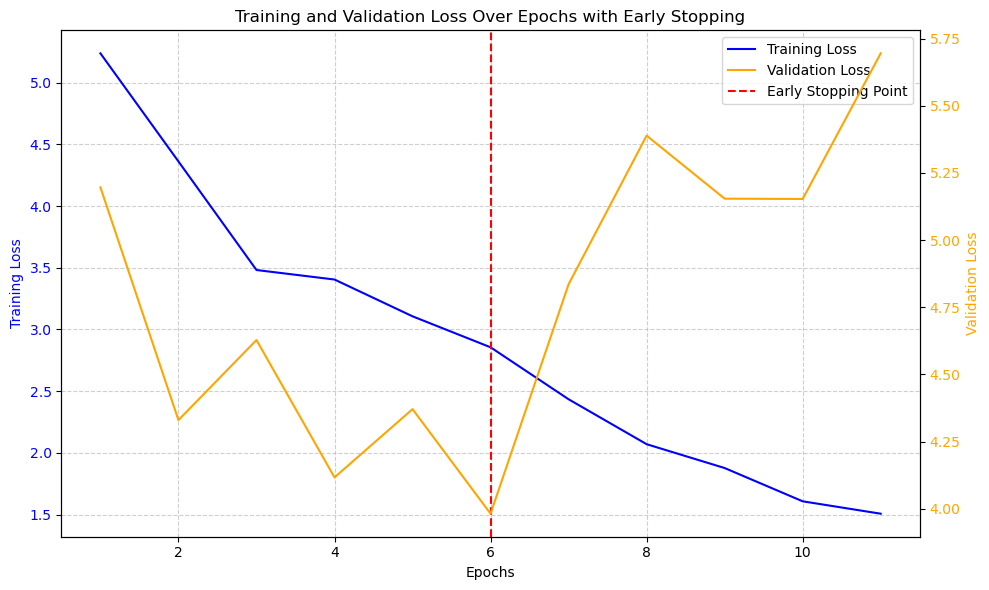

In [8]:
# Ensure train_losses and val_losses are aligned
min_len = min(len(train_losses), len(val_losses))  # Align lengths if different
train_losses = train_losses[:min_len]
val_losses = val_losses[:min_len]

# Identify the best epoch where early stopping occurred
best_epoch = min_len - patience_counter  # patience_counter tracks epochs without improvement

# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Initialize plot with size
line1 = ax1.plot(range(1, min_len + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')  # Label for X-axis
ax1.set_ylabel('Training Loss', color='b')  # Label for Y-axis on the left
ax1.tick_params(axis='y', labelcolor='b')  # Left Y-axis tick color
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid for clarity

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()  # Create twin axes for validation loss
line2 = ax2.plot(range(1, min_len + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')  # Label for Y-axis on the right
ax2.tick_params(axis='y', labelcolor='orange')  # Right Y-axis tick color

# Highlight Early Stopping Point
line3 = ax1.axvline(best_epoch, color='r', linestyle='--', label='Early Stopping Point')

# Combine Legends from Both Axes
lines = line1 + line2 + [line3]  # Combine lines from both Y-axes
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')  # Display legend

# Add Title and Final Touches
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()  # Adjust spacing to prevent overlap

# Display the Plot
plt.show()

In [9]:
# Test phase
model.eval()
test_tensor = torch.tensor(test_tensor, dtype=torch.float32)
test_los_label = torch.tensor(test_los_label, dtype=torch.float32)

with torch.no_grad():
    test_predictions = model(test_tensor)
    test_loss = criterion(test_predictions, test_los_label.unsqueeze(1))
    logging.info(f"Test Loss: {test_loss:.4f}")

C:\Users\Dimopoulos\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15312, 1, 1])) that is different to the input size (torch.Size([15312, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
2024-12-18 04:00:32,703 - INFO - Test Loss: 9.5734


In [10]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Ensure test and external datasets are PyTorch tensors
logging.info("Converting datasets to PyTorch tensors...")
X_test_tensor = test_tensor if isinstance(test_tensor, torch.Tensor) else torch.tensor(test_tensor, dtype=torch.float32)
y_test_tensor = test_los_label if isinstance(test_los_label, torch.Tensor) else torch.tensor(test_los_label, dtype=torch.float32)

X_external_tensor = external_tensor if isinstance(external_tensor, torch.Tensor) else torch.tensor(external_tensor, dtype=torch.float32)
y_external_tensor = external_los_label if isinstance(external_los_label, torch.Tensor) else torch.tensor(external_los_label, dtype=torch.float32)

# Create Datasets and DataLoaders
logging.info("Creating DataLoaders for Test and External Validation datasets...")
batch_size = 32  # Process data in smaller batches
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
external_dataset = TensorDataset(X_external_tensor, y_external_tensor)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
external_loader = DataLoader(external_dataset, batch_size=batch_size, shuffle=False)

# Model evaluation
logging.info("Starting model evaluation...")
model.eval()
y_test_preds = []
y_external_preds = []

# Predictions for Test Set
logging.info("Generating predictions for the Test Set...")
with torch.no_grad():
    for batch_idx, (X_batch, _) in enumerate(test_loader):
        logging.info(f"Processing Test Batch {batch_idx+1}/{len(test_loader)}")
        batch_preds = model(X_batch).squeeze()
        y_test_preds.append(batch_preds.cpu().numpy())  # Store predictions

# Predictions for External Validation Set
logging.info("Generating predictions for the External Validation Set...")
with torch.no_grad():
    for batch_idx, (X_batch, _) in enumerate(external_loader):
        logging.info(f"Processing External Batch {batch_idx+1}/{len(external_loader)}")
        batch_preds = model(X_batch).squeeze()
        y_external_preds.append(batch_preds.cpu().numpy())  # Store predictions

# Combine all batch predictions
logging.info("Combining all batch predictions...")
y_test_pred = np.concatenate(y_test_preds)
y_external_pred = np.concatenate(y_external_preds)

# Ground truth labels
y_test_true = y_test_tensor.numpy()
y_external_true = y_external_tensor.numpy()

# Calculate metrics for the Test Set
logging.info("Calculating metrics for the Test Set...")
test_mse = mean_squared_error(y_test_true, y_test_pred)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_true, y_test_pred) * 100  # R² in percentage

# Calculate metrics for the External Validation Set
logging.info("Calculating metrics for the External Validation Set...")
external_mse = mean_squared_error(y_external_true, y_external_pred)
external_mae = mean_absolute_error(y_external_true, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external_true, y_external_pred) * 100  # R² in percentage

# Print results
logging.info("Final Results:")
print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}%")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}%")

2024-12-18 04:00:32,722 - INFO - Converting datasets to PyTorch tensors...
2024-12-18 04:00:33,084 - INFO - Creating DataLoaders for Test and External Validation datasets...
2024-12-18 04:00:33,085 - INFO - Starting model evaluation...
2024-12-18 04:00:33,086 - INFO - Generating predictions for the Test Set...
2024-12-18 04:00:33,088 - INFO - Processing Test Batch 1/479
2024-12-18 04:00:33,369 - INFO - Processing Test Batch 2/479
2024-12-18 04:00:33,574 - INFO - Processing Test Batch 3/479
2024-12-18 04:00:33,752 - INFO - Processing Test Batch 4/479
2024-12-18 04:00:33,876 - INFO - Processing Test Batch 5/479
2024-12-18 04:00:34,003 - INFO - Processing Test Batch 6/479
2024-12-18 04:00:34,125 - INFO - Processing Test Batch 7/479
2024-12-18 04:00:34,263 - INFO - Processing Test Batch 8/479
2024-12-18 04:00:34,398 - INFO - Processing Test Batch 9/479
2024-12-18 04:00:34,518 - INFO - Processing Test Batch 10/479
2024-12-18 04:00:34,643 - INFO - Processing Test Batch 11/479
2024-12-18 04:0

Test Set - MSE: 3.94, MAE: 1.36, RMSE: 1.99, R2: 21.96%
External Validation - MSE: 5.09, MAE: 1.45, RMSE: 2.26, R2: -16.23%


Test Set MSE: 3.9413
Test Set MAE: 1.3592
Test Set RMSE: 1.9853
Test Set R2: 21.9575
Test Set MSLE: 0.1813


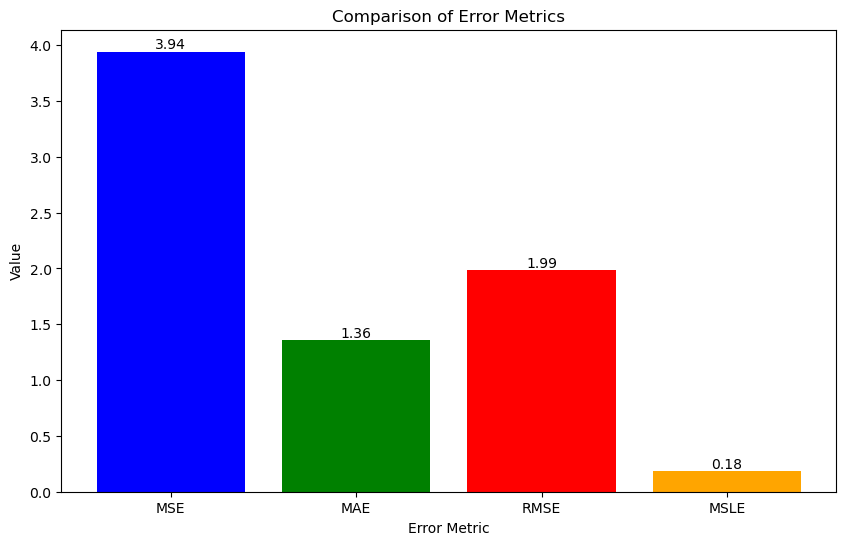

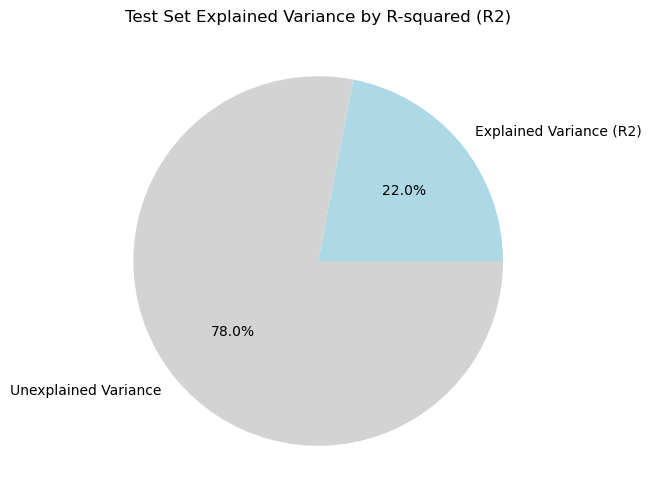

In [11]:
# Metrics calculation
mse = mean_squared_error(y_test_true, y_test_pred)
mae = mean_absolute_error(y_test_true, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_true, y_test_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test_true, y_test_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

#plt.savefig(f'plots/03_metrics/{file_name}_internal.png')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
#plt.savefig(f'plots/03_metrics/{file_name}_internal_R2.png')
plt.show()

External Validation Set MSE: 5.0944
External Validation Set MAE: 1.4451
External Validation Set RMSE: 2.2571
External Validation Set R2: -16.2348
External Validation Set MSLE: 0.2871


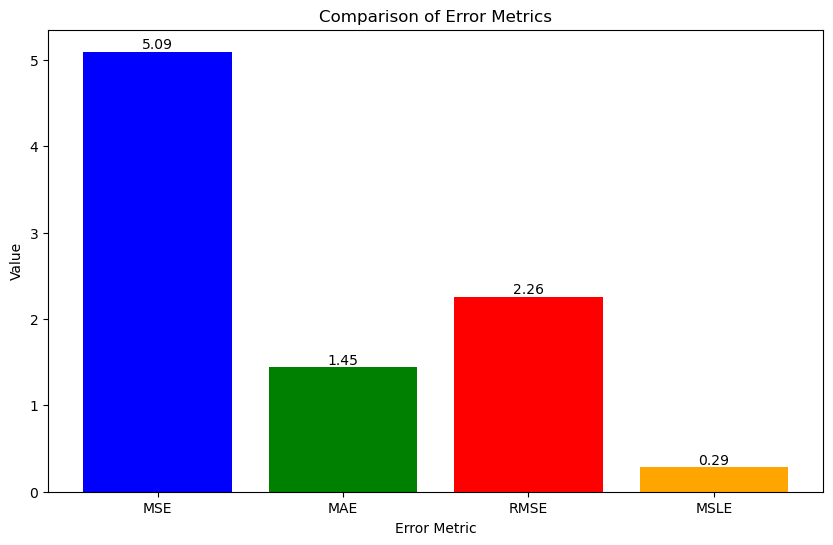

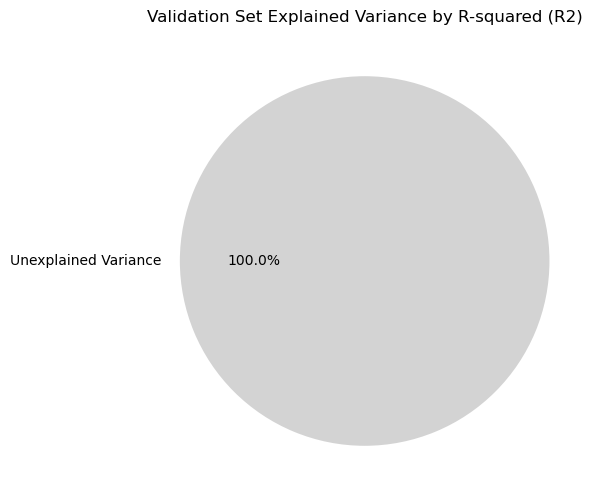

In [12]:
# Metrics for external validation set
mse_external = mean_squared_error(y_external_true, y_external_pred)
mae_external = mean_absolute_error(y_external_true, y_external_pred)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external_true, y_external_pred) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external_true, y_external_pred)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

#plt.savefig(f'plots/03_metrics/{file_name}_external.png')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
#plt.savefig(f'plots/03_metrics/{file_name}_external_R2.png')
plt.show()